# Models using all variables

In [23]:
import pandas as pd

X_train_std = pd.read_csv("./preprocessed_datasets/X_train_std.csv")
X_test_std = pd.read_csv("./preprocessed_datasets/X_test_std.csv")
y_train = pd.read_csv("./preprocessed_datasets/y_train.csv")
y_test = pd.read_csv("./preprocessed_datasets/y_test.csv")

Y values to array

In [24]:
import numpy as np

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Lineal regression models

In [25]:
X_train_std = X_train_std.drop(["index", "ID_Zenodo"], axis=1)

X_test_std = X_test_std.drop(["index", "ID_Zenodo"], axis=1)

### Lineal Regression

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

lr = LinearRegression(fit_intercept=True).fit(X_train_std ,y_train)
lr_r2_train = r2_score(y_train, lr.predict(X_train_std))
lr_r2_val = cross_val_score(lr, X_train_std, y_train, cv=5, scoring='r2').mean()
lr_r2_test = r2_score(y_test, lr.predict(X_test_std))

In [27]:
print(f"R2 train: {lr_r2_train}")
print(f"R2 val: {lr_r2_val}")
print(f"R2 test: {lr_r2_test}")

R2 train: 0.26987716862254574
R2 val: -1.0483073111949456e+25
R2 test: 0.2250432914504611


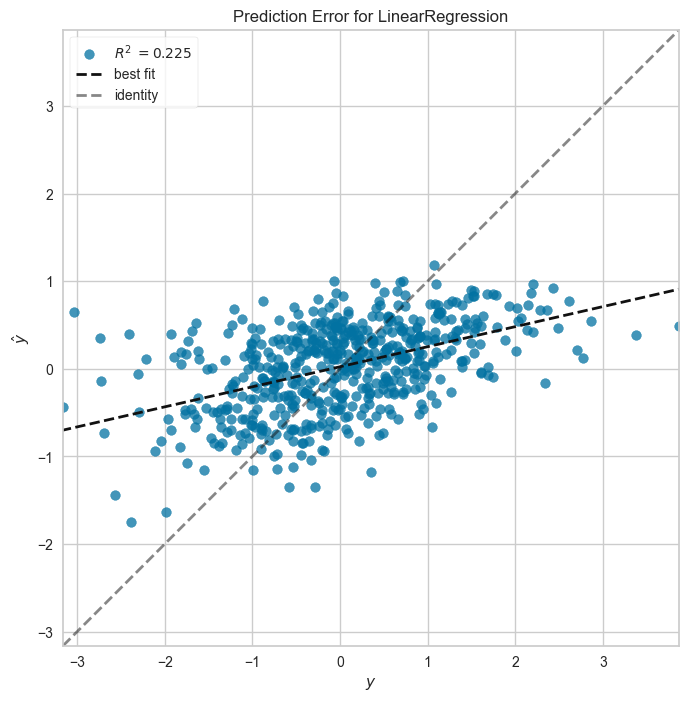

In [28]:
import matplotlib.pyplot as plt
from yellowbrick.regressor import prediction_error

plt.figure(figsize=(8,8))
visualizer = prediction_error(lr, X_test_std, y_test, is_fitted=True)

### Ridge Regression

In [29]:
from sklearn.model_selection import cross_val_score
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas=alpha, scoring="r2", cv=5).fit(X_train_std, y_train)
ridge_r2_test= ridge_cv.score(X_test_std, y_test)
ridge_r2_val = ridge_cv.best_score_
ridge_r2_val2 = np.mean(cross_val_score( RidgeCV(alphas=alpha, scoring="r2", cv=5), X_train_std, y_train, scoring="r2" ))
ridge_r2_train= ridge_cv.score(X_train_std, y_train)

print("Train R2: ", ridge_r2_train)
print("Validation R2: ", ridge_r2_val)
print("Validation R2: ", ridge_r2_val2)

print("Test R2: ", ridge_r2_test)
print(ridge_cv.alpha_)

Train R2:  0.26939216921699016
Validation R2:  0.23316062915784164
Validation R2:  0.23316062915784164
Test R2:  0.22587039875121628
100.0


### Lasso Regression

In [30]:
alpha = [1e-3, 1e-2, 1e-1, 1, 100]
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=0, alphas=alpha).fit(X_train_std, y_train)
lasso_r2_test= lasso_cv.score(X_test_std, y_test)
lasso_r2_val = np.mean(cross_val_score( LassoCV(alphas=alpha, random_state=0, cv=5), X_train_std, y_train, scoring="r2" ))
lasso_r2_train= lasso_cv.score(X_train_std, y_train)

print("Train R2: ", lasso_r2_train)
print("Validation R2: ", lasso_r2_val)
print("Test R2: ", lasso_r2_test)
print(lasso_cv.alpha_)

Train R2:  0.26360680226557387
Validation R2:  0.23600059487316294
Test R2:  0.22161614470057955
0.01


In [31]:
r2_results = pd.DataFrame({'LR': lr_r2_train, 'Ridge': ridge_r2_train, 'Lasso': lasso_r2_train,}, index=['Train R2'])


print([lr_r2_val, ridge_r2_val, lasso_r2_val])
lr_r2_val = np.mean(lr_r2_val)
r2_results.loc['CV (Val) R2', :] = [lr_r2_val, ridge_r2_val, lasso_r2_val]
r2_results.loc['Test R2', :] = [lr_r2_test, ridge_r2_test, lasso_r2_test]


r2_results.loc['lambda','LR']=0
r2_results.loc['lambda','Ridge']=ridge_cv.alpha_
r2_results.loc['lambda','Lasso']=lasso_cv.alpha_
r2_results


[-1.0483073111949456e+25, 0.23316062915784164, 0.23600059487316294]


,LR,Ridge,Lasso
Train R2,2.698772e-01,0.269392,0.263607
CV (Val) R2,-1.048307e+25,0.233161,0.236001
Test R2,2.250433e-01,0.225870,0.221616
lambda,0.000000e+00,100.000000,0.010000


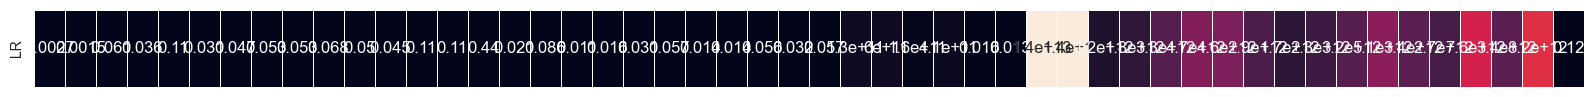

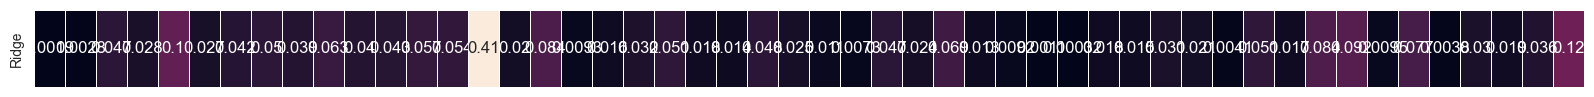

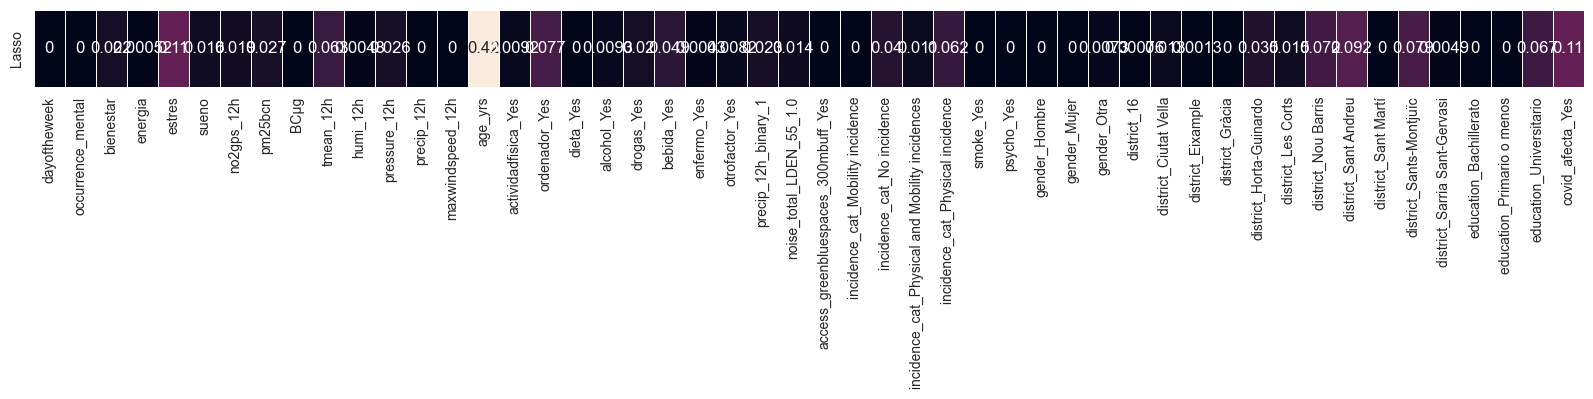

In [32]:

import matplotlib.pyplot as plt
import seaborn as sns

weights = pd.DataFrame({'LR':lr.coef_, 'Ridge':ridge_cv.coef_, 'Lasso':lasso_cv.coef_},index=X_train_std.columns)

fig, ax = plt.subplots(figsize = (20,1))
sns.heatmap(weights.T.loc[['LR'],:].abs(), annot=True, linewidths=.5, ax=ax, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Ridge'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=False);

plt.figure(figsize = (20,1))
sns.heatmap(weights.T.loc[['Lasso'],:].abs(), annot=True, linewidths=.5, cbar=False, xticklabels=True);

# MLP (Multi Layer Perceptron)

In [65]:
# Plot leaning curves
def plot_curves(history):

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_accuracy = history.history['mean_squared_error']
  val_accuracy = history.history['val_mean_squared_error']
  epochs = range(1, len(train_loss) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  axes[0].plot(epochs, train_loss, 'g-', label='Training Loss')
  axes[0].plot(epochs, val_loss, 'orange', label='Validation Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(epochs, train_accuracy, 'g-', label='Training mean_squared_error')
  axes[1].plot(epochs, val_accuracy, 'orange', label='Validation mean_squared_error')
  axes[1].set_title('Training and Validation mean_squared_error')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('mean_squared_error')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()

  plt.show()


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,  Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from tensorflow.keras import regularizers

## First iteration

In [ ]:

callback = EarlyStopping(monitor='loss',patience=3)

model = Sequential([
    Dense(256, activation='elu', input_shape=(X_train_std.shape[1],)),
    Dense(1)
])
# Define the optimizer and learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error',patience=15)

# Train the model
num_epochs = 1000
batch_size = 32
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))



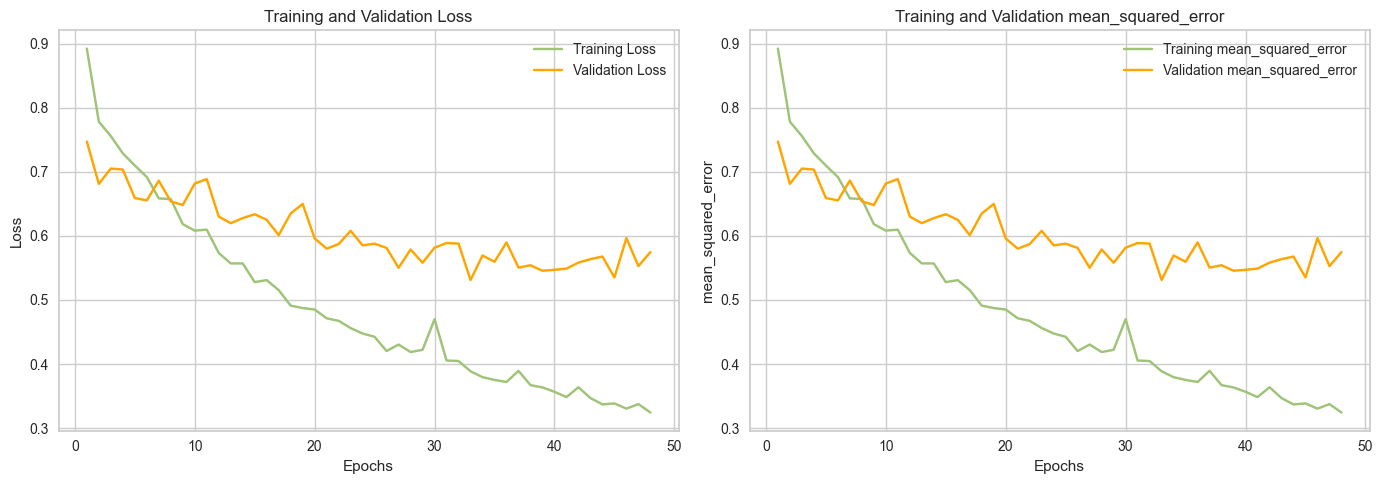

In [34]:
plot_curves(history)

## Second iteration

In [35]:
# Define the model
model = Sequential([
    Dense(256, activation='leaky_relu', input_shape=(X_train_std.shape[1],)),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.5),           # Add Dropout for regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Batch Normalization after the second hidden layer
    Dense(64, activation='relu'),   # Add another hidden layer
    Dense(1)               # Output layer
])

# Define the optimizer with momentum
learning_rate = 0.001
momentum = 0.95
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=15)

# Train the model
num_epochs = 1000
batch_size = 64  # Adjusted batch size
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.6273 - mean_squared_error: 1.6273 - val_loss: 0.7815 - val_mean_squared_error: 0.7815
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9841 - mean_squared_error: 0.9841 - val_loss: 0.7726 - val_mean_squared_error: 0.7726
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9243 - mean_squared_error: 0.9243 - val_loss: 0.7551 - val_mean_squared_error: 0.7551
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7993 - mean_squared_error: 0.7993 - val_loss: 0.7045 - val_mean_squared_error: 0.7045
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7515 - mean_squared_error: 0.7515 - val_loss: 0.6803 - val_mean_squared_error: 0.6803
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7263 - mean_squared_error: 0.7263 - val_loss: 0.6488 - val_mean_squared_error: 0.6488
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7306 - mean_squared_error: 0.7306 - val_loss: 0

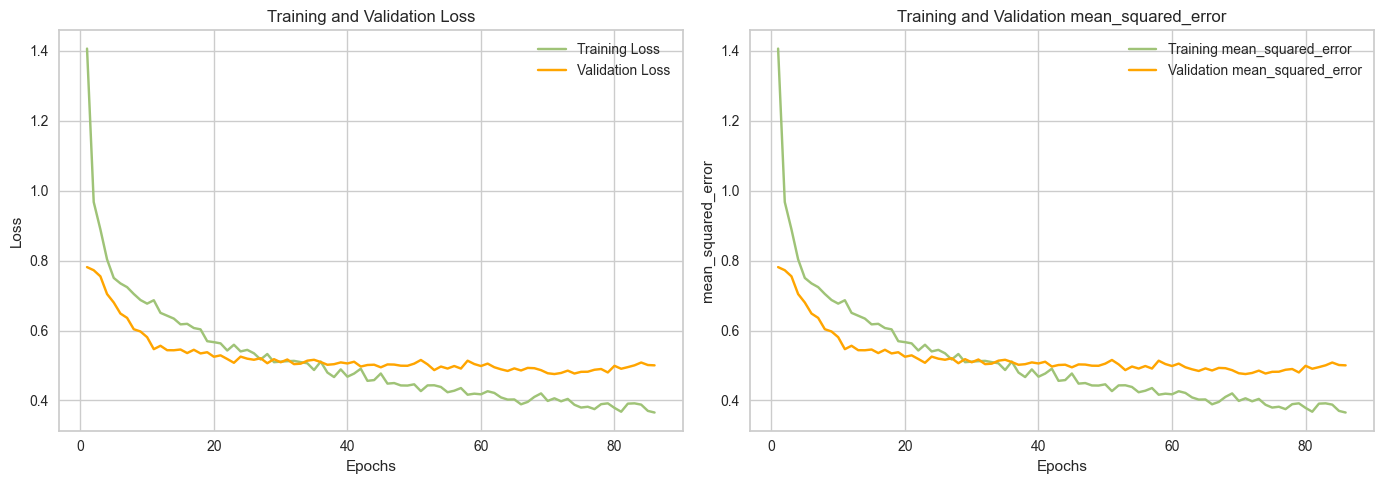

In [36]:
plot_curves(history)

## Third iteration

In [38]:
# Define the model
model = Sequential([
    Dense(256, activation='leaky_relu', input_shape=(X_train_std.shape[1],)),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.7),           # Add Dropout for regularization
    Dense(128, activation='relu'),  # Add another hidden layer
    BatchNormalization(),  # Batch Normalization after the second hidden layer
    Dense(64, activation='relu'),   # Add another hidden layer
    Dense(1)               # Output layer
])

# Define the optimizer with momentum
learning_rate = 0.001
momentum = 0.98
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

# Use Huber loss as the loss function
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

# Compile the model with Huber loss
model.compile(optimizer=optimizer, loss=huber_loss, metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=40)

# Train the model
num_epochs = 1000
batch_size = 64  # Adjusted batch size
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.6528 - mean_squared_error: 1.7915 - val_loss: 0.3858 - val_mean_squared_error: 0.8908
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4958 - mean_squared_error: 1.2604 - val_loss: 0.3699 - val_mean_squared_error: 0.8482
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4234 - mean_squared_error: 1.0207 - val_loss: 0.3661 - val_mean_squared_error: 0.8398
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3953 - mean_squared_error: 0.9497 - val_loss: 0.3552 - val_mean_squared_error: 0.8108
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3654 - mean_squared_error: 0.8662 - val_loss: 0.3404 - val_mean_squared_error: 0.7710
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3804 - mean_squared_error: 0.9134 - val_loss: 0.3291 - val_mean_squared_error: 0.7421
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3711 - mean_squared_error: 0.8765 - val_loss: 0.3

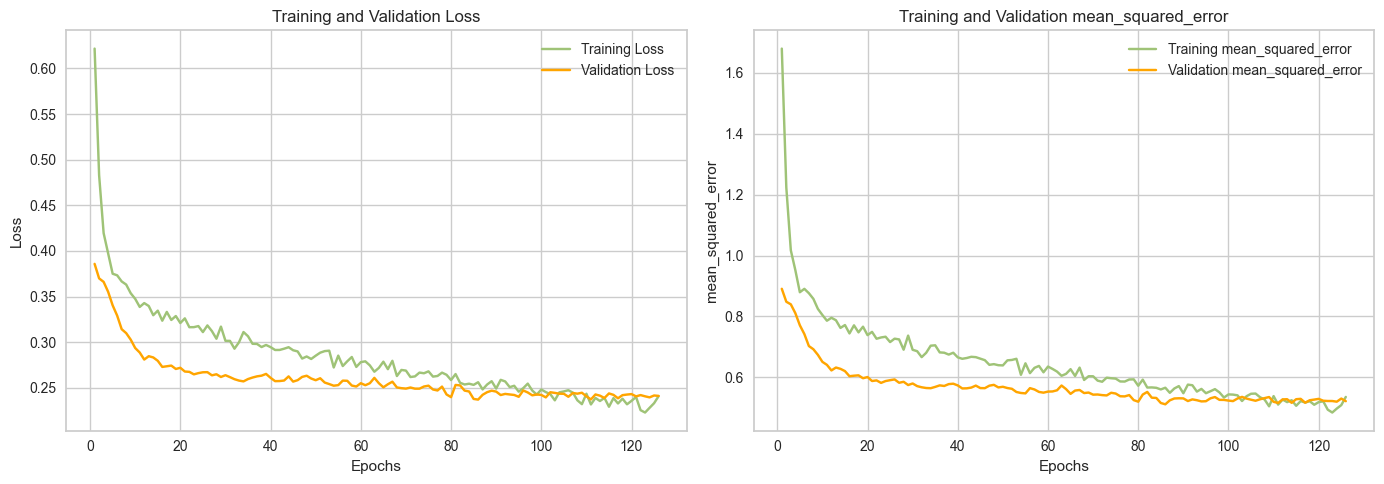

In [39]:
plot_curves(history)

## Fourth iteration

In [40]:
# Define the model
model = Sequential([
    Dense(300, activation='leaky_relu', input_shape=(X_train_std.shape[1],),kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),  # Add Batch Normalization
    Dropout(0.5),           # Add Dropout for regularization
    Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Add another hidden layer
    BatchNormalization(),  # Batch Normalization after the second hidden layer
    Dense(75, activation='relu'),   # Add another hidden layer
    Dense(1)               # Output layer
])

# Define the optimizer with momentum
learning_rate = 0.01
momentum = 0.90
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

# Use Huber loss as the loss function
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

# Compile the model with Huber loss
model.compile(optimizer=optimizer, loss="huber", metrics=['mean_squared_error'])
callback = EarlyStopping(monitor='val_mean_squared_error', patience=40)

# Train the model
num_epochs = 1000
batch_size = 256  # Adjusted batch size
history = model.fit(X_train_std, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[callback])

# Evaluate the model
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Training MSE: {:.4f}'.format(train_mse))
print('Testing MSE: {:.4f}'.format(test_mse))
print('Training R-squared: {:.4f}'.format(train_r2))
print('Testing R-squared: {:.4f}'.format(test_r2))


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 3.6003 - mean_squared_error: 2.1561 - val_loss: 3.2649 - val_mean_squared_error: 0.9728
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3702 - mean_squared_error: 1.3908 - val_loss: 3.1599 - val_mean_squared_error: 0.8691
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.2178 - mean_squared_error: 1.1067 - val_loss: 3.0720 - val_mean_squared_error: 0.8372
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0721 - mean_squared_error: 0.9211 - val_loss: 2.9819 - val_mean_squared_error: 0.8163
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.9480 - mean_squared_error: 0.8013 - val_loss: 2.8962 - val_mean_squared_error: 0.8066
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.8658 - mean_squared_error: 0.7830 - val_loss: 2.8126 - val_mean_squared_error: 0.7974
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.7846 - mean_squared_error: 0.7942 - val_loss: 2.7295 - va

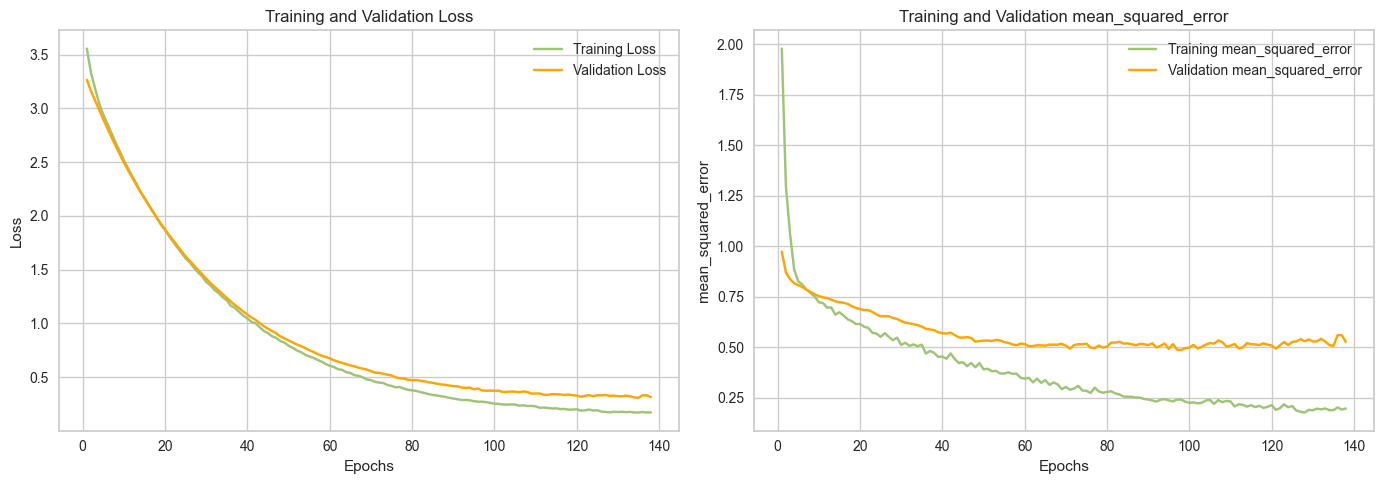

In [41]:
plot_curves(history)

### Utilitzant MLPRegressor

In [45]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(2000,), random_state=1, max_iter=500).fit(X_train_std, y_train)

regr.score(X_test_std, y_test)

0.38989661935150033